라이브러리 로드

In [41]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import pytorch_model_summary

GPU 설정

In [51]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

데이터 로드

In [116]:
transform=transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.1307,),(0.3081))])

In [117]:
trainset=datasets.FashionMNIST(root='content',
train=True,download=True,
transform=transform)

testset=datasets.FashionMNIST(root='content',
train=False,download=True,
transform=transform)

In [118]:
print(len(trainset))
print(len(testset))

60000
10000


In [119]:
train_loader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=6)
test_loader=DataLoader(testset,batch_size=128,shuffle=False,num_workers=6)

In [120]:
images,labels=next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [121]:
steps_per_epoch=len(train_loader)
print(steps_per_epoch)

469


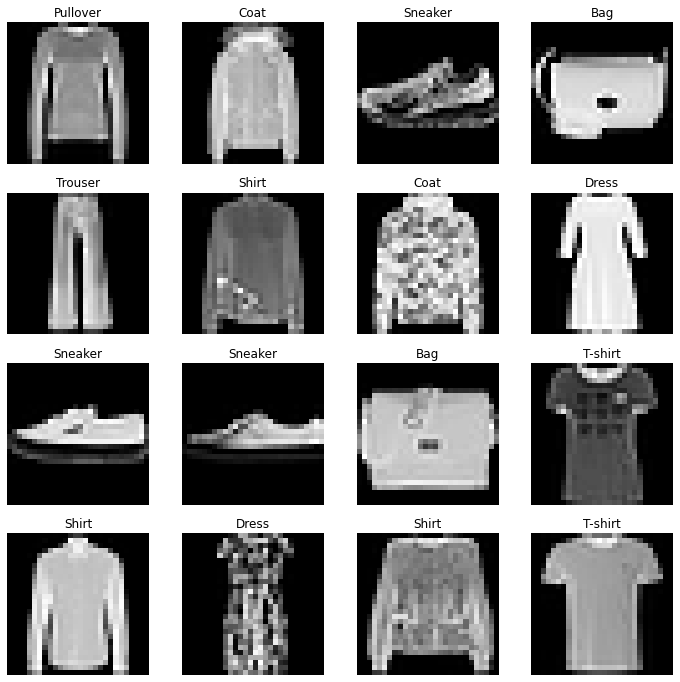

In [122]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

figure=plt.figure(figsize=(12,12))
cols,rows=4,4
for i in range(1,cols*rows+1):
    image=images[i].squeeze()
    label_idx=labels[i].item()
    label=classes[label_idx]

    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image,cmap='gray')

plt.show()

학습된 모델(pretrained model) 로드

In [123]:
model = models.efficientnet_b0(pretrained=True)
model.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
 

weight로 학습된 모델 확인

In [124]:
for param in model.parameters():
  print(param.data)

tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
          [-1.1092e-01, -6.1004e-01, -3.3345e-01],
          [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],

         [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
          [-1.3646e-01, -1.5367e+00, -1.5937e+00],
          [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],

         [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
          [-1.1966e-01, -2.8122e-01, -2.1883e-01],
          [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],


        [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
          [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
          [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],

         [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
          [ 1.6213e+00, -2.1188e+00,  4.1014e-01],
          [ 1.7230e+00, -2.0756e+00,  3.3958e-01]],

         [[ 9.5290e-02, -1.5971e-01,  7.4559e-02],
          [ 8.0502e-01, -9.7034e-01,  2.6280e-01],
          [ 7.1944e-01, -1.0026e+00,  1.9870e-01]]],


        [[[ 5.3857e-02,  2.6367e-01,  1.1696e-01],
          [ 9.1

모델 정의

In [129]:
class MyEfficientNet(nn.Module):
    def __init__(self):
        super(MyEfficientNet,self).__init__()
        self.conv=nn.Conv2d(1,3,3).to(device)
        self.batchN1=nn.BatchNorm2d(3)
        self.network=model.to(device)
        self.batchN2=nn.BatchNorm1d(1000)
        self.lin=nn.Linear(1000,10).to(device)
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv(x)),(2,2)).to(device)
        x=self.batchN1(x)
        x=F.relu(self.network(x)).to(device)
        x=self.batchN2(x)
        x=self.lin(x)
        return x

In [130]:
mynet=MyEfficientNet()
mynet.to(device)
print(mynet)

MyEfficientNet(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchN1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (network): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), strid

In [131]:
params=list(mynet.parameters())
print(len(params))
print(params[0].size())

221
torch.Size([3, 1, 3, 3])


In [132]:
print(pytorch_model_summary.summary(mynet, torch.zeros(128, 1, 128, 128).to(device), show_input=True))

--------------------------------------------------------------------------
      Layer (type)            Input Shape         Param #     Tr. Param #
          Conv2d-1     [128, 1, 128, 128]              30              30
     BatchNorm2d-2       [128, 3, 63, 63]               6               6
    EfficientNet-3       [128, 3, 63, 63]       5,288,548       5,288,548
     BatchNorm1d-4            [128, 1000]           2,000           2,000
          Linear-5            [128, 1000]          10,010          10,010
Total params: 5,300,594
Trainable params: 5,300,594
Non-trainable params: 0
--------------------------------------------------------------------------


손실함수와 옵티마이저

In [133]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(mynet.parameters(), lr=0.0001, momentum=0.9)

TensorBoard 설정

In [134]:
from torch.utils.tensorboard import SummaryWriter

# 기본 `log_dir` 은 "runs"이며, 여기서는 더 구체적으로 지정하였습니다
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

TensorBoard 기록

In [135]:
# 임의의 학습 이미지를 가져옵니다
dataiter = iter(train_loader)
images, labels = dataiter.next()
images=images.to(device)
labels=labels.to(device)

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

In [136]:
writer.add_graph(mynet, images)
writer.close()

In [137]:
%tensorboard --logdir=runs

UsageError: Line magic function `%tensorboard` not found.


모델 학습

In [138]:
batch_size=128 # 학습할 때 얼마나 많은 데이터를 이용할 것인가 
steps_per_epoch=len(train_loader) # 한 epoch 당 스텝 수 (batch_size크기의 데이터 개수)

# epoch 수는 100
for epoch in range(100):
    running_loss=0.0 # 초기 누적 오차 = 0 
    batch_acc_list=[] # batch 별 accuracy list

    # step (steps_per_epoch:469)
    for i, data in enumerate(train_loader,0):
        # 데이터 입력
        inputs, labels=data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # Gradient -> 0
        optimizer.zero_grad()
        # 순전파+역전파+최적화 
        outputs=mynet(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        # 누적 오차 
        running_loss +=loss.item()

        # batch_accuracy 계산 (한 스텝마다 accuracy 저장)
        _,predicted=torch.max(outputs.data,1)
        correct=(predicted==labels).sum().item()
        batch_acc = correct/batch_size * 100
        batch_acc_list.append(batch_acc)

        # 100 스텝마다 출력 (100x128개 데이터마다 출력)
        if i % 100 == 99:
            # 학습 중 손실(running loss)을 기록
            writer.add_scalar('training loss',
                            running_loss / steps_per_epoch,
                            epoch * len(train_loader) + i)
            print('Epoch: {}, Iter: {}, Loss:{}'.format(epoch+1,i+1,running_loss/steps_per_epoch))
            running_loss=0.0

    # epoch마다 accuracy 출력
    epoch_acc=np.mean(batch_acc_list) # batch_accuracy_list의 평균으로 계산 (전체 데이터를 기준)
    print('Epoch: {}, Acc:{}'.format(epoch+1,epoch_acc))
        

Epoch: 1, Iter: 100, Loss:0.5138222947557852
Epoch: 1, Iter: 200, Loss:0.4930205045224253
Epoch: 1, Iter: 300, Loss:0.47705206230505187
Epoch: 1, Iter: 400, Loss:0.4545022607612203
Epoch: 1, Acc:18.63006396588486
Epoch: 2, Iter: 100, Loss:0.41645067434575256
Epoch: 2, Iter: 200, Loss:0.3974805884778118
Epoch: 2, Iter: 300, Loss:0.3784306791545486
Epoch: 2, Iter: 400, Loss:0.36086314217622345
Epoch: 2, Acc:39.75712953091684
Epoch: 3, Iter: 100, Loss:0.3320403925137225
Epoch: 3, Iter: 200, Loss:0.3170645928332038
Epoch: 3, Iter: 300, Loss:0.3046604585545912
Epoch: 3, Iter: 400, Loss:0.287681740484258
Epoch: 3, Acc:53.83795309168443
Epoch: 4, Iter: 100, Loss:0.26198927451298437
Epoch: 4, Iter: 200, Loss:0.2539809090750558
Epoch: 4, Iter: 300, Loss:0.24233122942035895
Epoch: 4, Iter: 400, Loss:0.2343009702686562
Epoch: 4, Acc:63.39952025586354
Epoch: 5, Iter: 100, Loss:0.2177148631640843
Epoch: 5, Iter: 200, Loss:0.21324865027531378
Epoch: 5, Iter: 300, Loss:0.20788479448635694
Epoch: 5, I

모델 저장

In [157]:
path='./fashion_mnist.pth'
torch.save(mynet.state_dict(), path)
mynet_=MyEfficientNet()
mynet_.load_state_dict(torch.load(path))  # 모델 로드 (저장된 파라미터로 업데이트)
mynet_.to(device)

MyEfficientNet(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchN1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (network): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), strid

모델 테스트

In [158]:
correct=0
total=0

with torch.no_grad():
    for data in test_loader:
        images, labels=data
        images=images.to(device)
        labels=labels.to(device)
        outputs=mynet_(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print(correct/total*100)

85.38


TensorBoard로 학습된 모델 평가

In [164]:
# 1. 예측 확률을 test_size x num_classes 텐서로 가져옵니다
# 2. 예측 결과를 test_size 텐서로 가져옵니다
class_probs = []
class_label = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        output = mynet_(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs,test_label)

In [162]:
%tensorboard --logdir=runs

UsageError: Line magic function `%tensorboard` not found.


프로세스 종료

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)